In [1]:
import xarray as xr
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors
from scipy import stats

In [2]:
home_folder = "/nethome/manra003/analysis/dispersion/simulations/"
# ds1 = xr.open_zarr(home_folder + "Fwd_2D_Luderitz_117x117_Nov01-31_2017_0z_100days.zarr")
# ds2 = xr.open_zarr(home_folder + "Fwd_3D_Luderitz_117x117_Nov01-31_2017_0z_100days.zarr")  
# ds3 = xr.open_zarr(home_folder + "Fwd_DVM_Luderitz_117x117_Nov01-31_2017_1z_100days.zarr") 
 
ds1 = xr.open_zarr(home_folder + "Fwd_2D_Jul2023_BenguelaUpwR_117x117_Dec2017_1z_100days.zarr")
ds2 = xr.open_zarr(home_folder + "Fwd_3D_Jul2023_BenguelaUpwR_117x117_Dec2017_1z_100days.zarr")  
ds3 = xr.open_zarr(home_folder + "Fwd_DVM_Jul2023_BenguelaUpwR_117x117_Dec2017_1z_100days.zarr") 

In [120]:
# Parallelised code from - Michael Denes
def distance(lon1, lat1, lon2, lat2,  mask_value, r=6378):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """

    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    if np.isnan([lon1, lon2, lat1, lat2]).any():
        return mask_value
    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    c = np.multiply(2, np.arcsin(np.sqrt(a)))

    return c*r

In [121]:
t_days = 100
p_total = 370831
# sep_array_1_2 = np.empty((p_total, t_days))
# sep_array_1_3 = np.empty((p_total, t_days))
# sep_array_2_3 = np.empty((p_total, t_days))
# sep_array_1_2[:] = np.nan
# sep_array_1_3[:] = np.nan
# sep_array_2_3[:] = np.nan
unreal_d = 99999.0
sep_array_1_2 = np.full((p_total, t_days), unreal_d)
sep_array_1_3 = np.full((p_total, t_days), unreal_d)
sep_array_2_3 = np.full((p_total, t_days), unreal_d)


<h3> compute absolute distance between particles in different cases

In [ ]:
for time_step in range(t_days):
    sep_array_1_2[:, time_step] = distance(ds1['lon'][:, time_step], ds1['lat'][:, time_step], ds2['lon'][:, time_step], ds2['lat'][:, time_step], unreal_d)
    sep_array_1_3[:, time_step] = distance(ds1['lon'][:, time_step], ds1['lat'][:, time_step], ds3['lon'][:, time_step], ds3['lat'][:, time_step], unreal_d)
    sep_array_2_3[:, time_step] = distance(ds2['lon'][:, time_step], ds2['lat'][:, time_step], ds3['lon'][:, time_step], ds3['lat'][:, time_step], unreal_d)

In [113]:
np.min(ds1['lat'][:, 99])


nan

In [6]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,:,:,:]

In [7]:
def get_axes(ax):
    custom_size=10
    gl = ax.gridlines(draw_labels=True)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': custom_size, 'color': 'k'}
    gl.ylabel_style = {'size': custom_size, 'color': 'k'}

    colormap = colors.ListedColormap(['gainsboro', 'white'])

    ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 0,1250:1750, 1500:], cmap=colormap)
    ax.set_xlim(3,17)
    ax.set_ylim(-30,-15)
    return ax

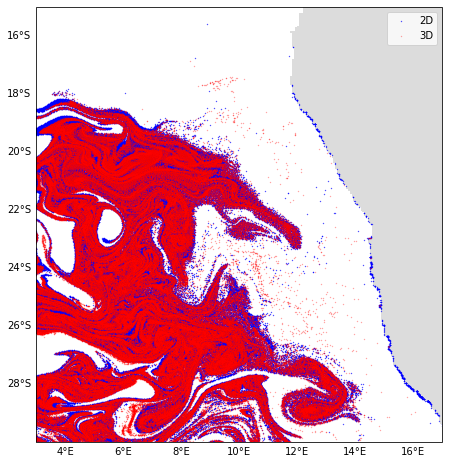

In [8]:
fig= plt.figure(figsize=(16, 8))
time_step= 100

ax = plt.axes(projection=ccrs.PlateCarree())
ax = get_axes(ax)
ax.scatter(ds1['lon'][:, time_step], ds1['lat'][:, time_step], s=0.1, c='blue',label="2D")
ax.scatter(ds2['lon'][:, time_step], ds2['lat'][:, time_step], s=0.1, c='red', label="3D", alpha=0.5)
ax.legend()

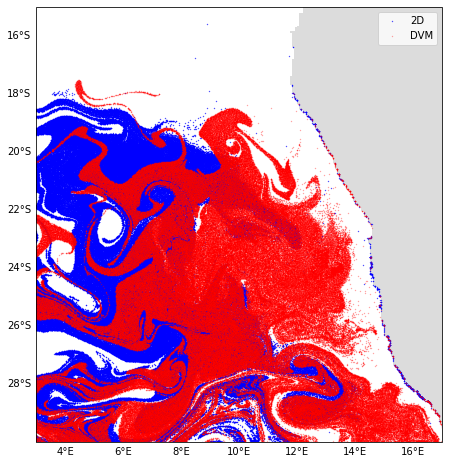

In [9]:
fig= plt.figure(figsize=(16, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax = get_axes(ax)
ax.scatter(ds1['lon'][:, time_step], ds1['lat'][:, time_step], s=0.1, c='blue',label="2D")
ax.scatter(ds3['lon'][:, time_step], ds3['lat'][:, time_step], s=0.1, c='red', label="DVM", alpha=0.5)
ax.legend()

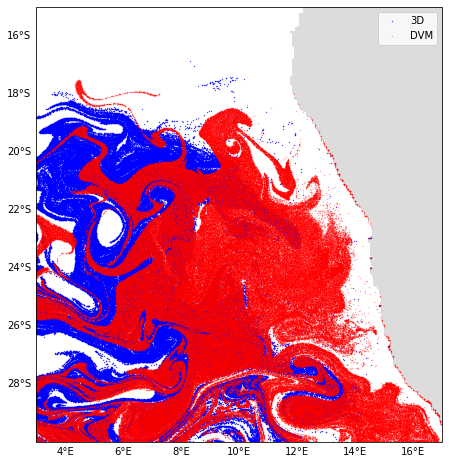

In [10]:
fig= plt.figure(figsize=(16, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax = get_axes(ax)
ax.scatter(ds2['lon'][:, time_step], ds2['lat'][:, time_step], s=0.1, c='blue',label="3D")
ax.scatter(ds3['lon'][:, time_step], ds3['lat'][:, time_step], s=0.1, c='red', label="DVM", alpha=0.5)
ax.legend()

<h3> compute 95 percentile of particles distance for each day

In [11]:
t_step=99
print(min(sep_array_1_2[:,t_step]),max(sep_array_1_2[:,t_step]))
print(min(sep_array_1_3[:,t_step]),max(sep_array_1_3[:,t_step]))
print(min(sep_array_2_3[:,t_step]),max(sep_array_2_3[:,t_step]))

# assert np.equal(sep_array_1_2[:,t_step],sep_array_1_3[:,t_step]).all() 

percentile_95_1_2 = np.percentile(sep_array_1_2, 95, axis=0)
percentile_95_1_3 = np.percentile(sep_array_1_3, 95, axis=0)
percentile_95_2_3 = np.percentile(sep_array_2_3, 95, axis=0)

print(min(percentile_95_1_2),max(percentile_95_1_2))
print(min(percentile_95_1_3),max(percentile_95_1_3))
print(min(percentile_95_2_3),max(percentile_95_2_3))



0.0 1567.1221649585282
0.0 1729.9914350490262
0.0 1578.5935865002618
0.0 67.81597258014465
0.0 335.3282262367393
0.0 332.29910785393133


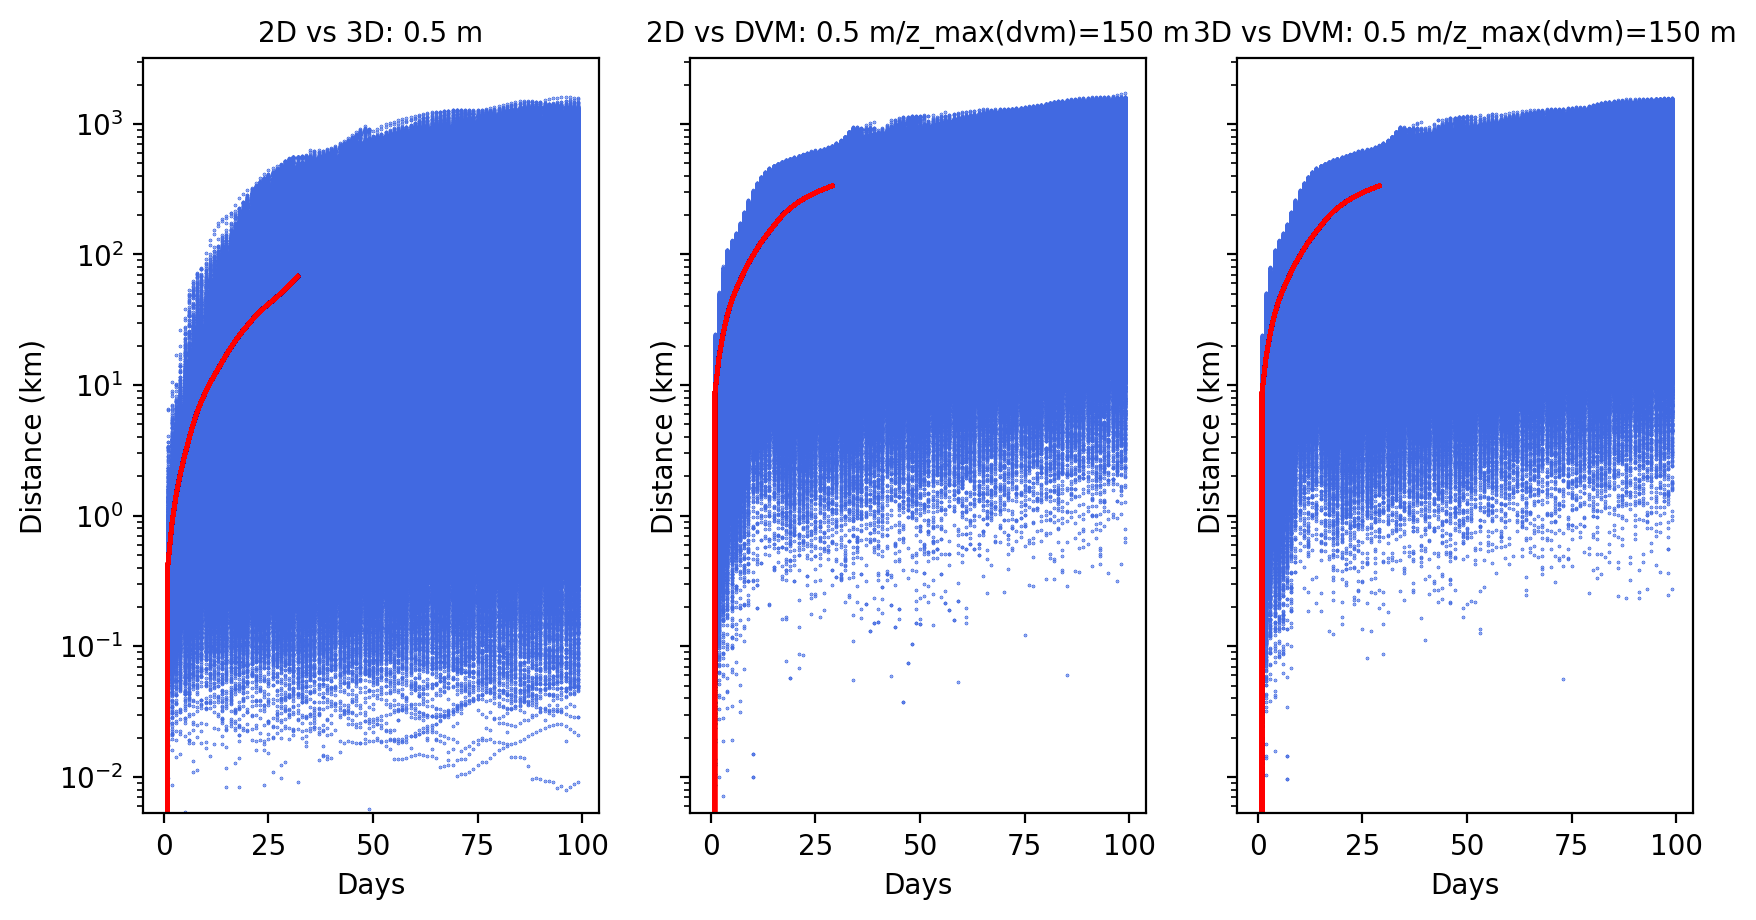

In [12]:
custom_size=10
fig, ax = plt.subplots(ncols=3, nrows=1, dpi=200, figsize=(10, 5), sharey=True)
for i in range(100):
    ax[0].title.set_text('2D vs 3D: 0.5 m')
    ax[0].title.set_fontsize(10)
    ax[0].scatter(np.full((p_total), i), sep_array_1_2[:,i], s=0.1,c='royalblue', zorder=1)
    ax[0].plot(percentile_95_1_2, c='red',zorder=2)
    ax[0].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[0].set_xlabel('Days', fontsize=custom_size)
    ax[0].set_yscale('log')

    ax[1].title.set_text('2D vs DVM: 0.5 m/z_max(dvm)=150 m')
    ax[1].title.set_fontsize(10)
    ax[1].scatter(np.full((p_total), i), sep_array_1_3[:,i], s=0.1,c='royalblue', zorder=1)
    ax[1].plot(percentile_95_1_3, c='red',zorder=2)
    ax[1].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[1].set_xlabel('Days', fontsize=custom_size)
    ax[1].set_yscale('log')

    ax[2].title.set_text('3D vs DVM: 0.5 m/z_max(dvm)=150 m')
    ax[2].title.set_fontsize(10)
    ax[2].scatter(np.full((p_total), i), sep_array_2_3[:,i], s=0.1,c='royalblue', zorder=1)
    ax[2].plot(percentile_95_1_3, c='red',zorder=2)
    ax[2].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[2].set_xlabel('Days', fontsize=custom_size)
    ax[2].set_yscale('log')



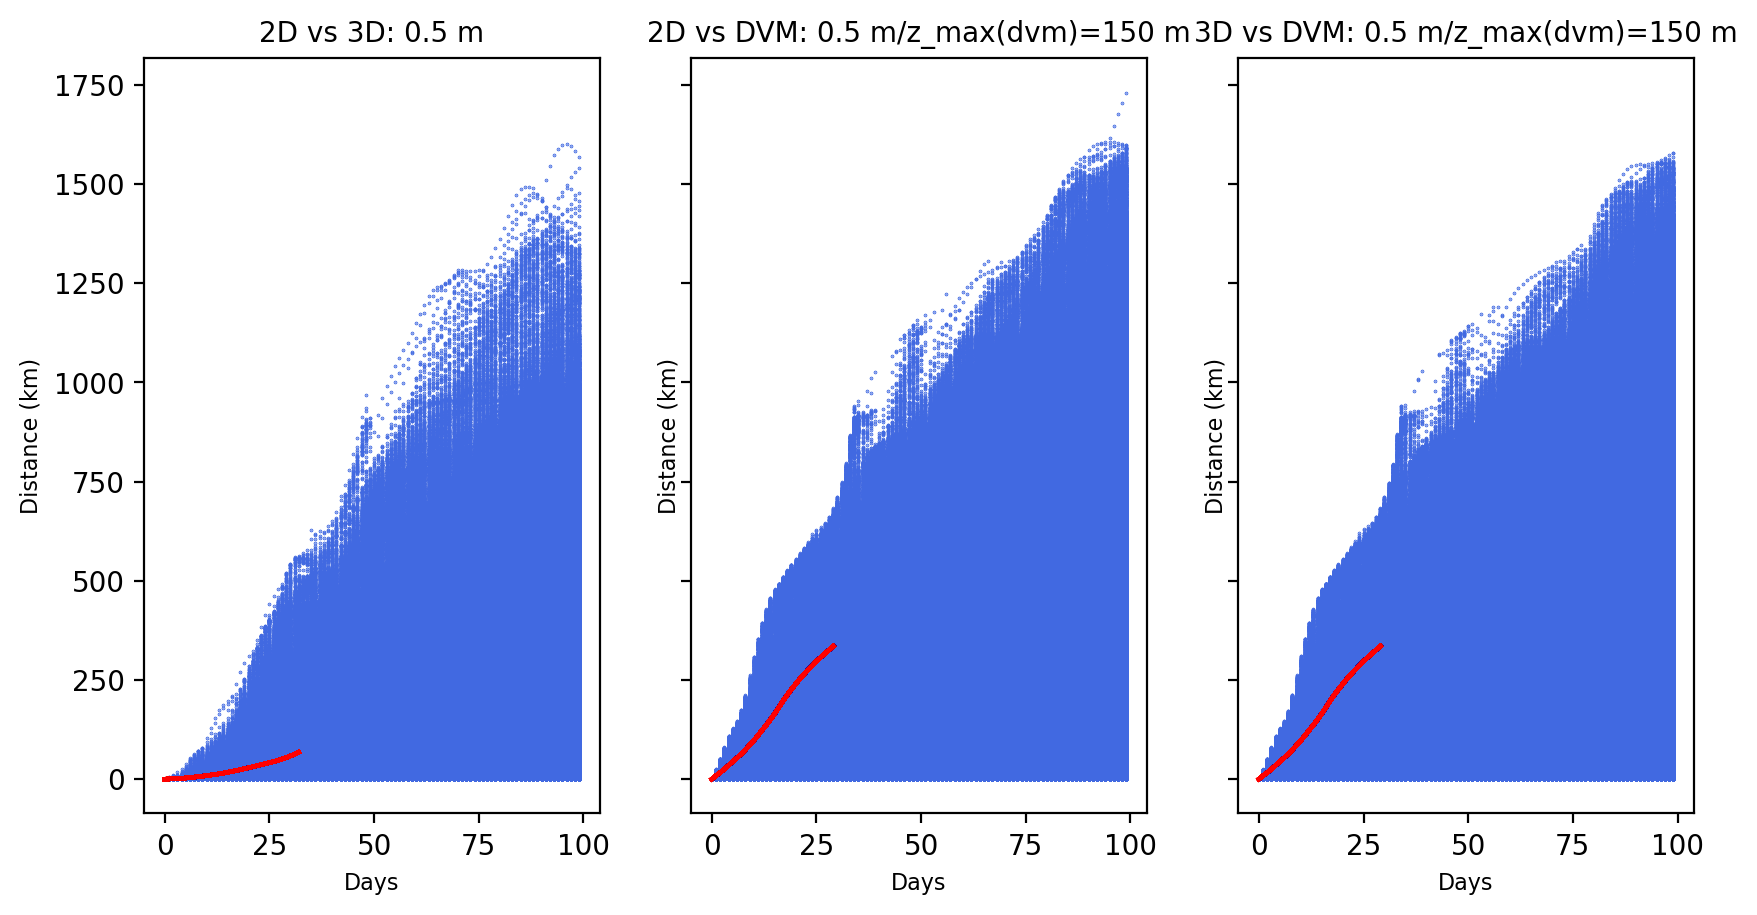

In [13]:
custom_size=8
fig, ax = plt.subplots(ncols=3, nrows=1, dpi=200, figsize=(10, 5), sharey=True)
for i in range(100):
    ax[0].title.set_text('2D vs 3D: 0.5 m')
    ax[0].title.set_fontsize(10)
    ax[0].scatter(np.full((p_total), i), sep_array_1_2[:,i], s=0.1,c='royalblue', zorder=1)
    ax[0].plot(percentile_95_1_2, c='red',zorder=2)
    ax[0].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[0].set_xlabel('Days', fontsize=custom_size)

    ax[1].title.set_text('2D vs DVM: 0.5 m/z_max(dvm)=150 m')
    ax[1].scatter(np.full((p_total), i), sep_array_1_3[:,i], s=0.1,c='royalblue', zorder=1)
    ax[1].plot(percentile_95_1_3, c='red',zorder=2)
    ax[1].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[1].set_xlabel('Days', fontsize=custom_size)
    ax[1].title.set_fontsize(10)

    ax[2].title.set_text('3D vs DVM: 0.5 m/z_max(dvm)=150 m')
    ax[2].scatter(np.full((p_total), i), sep_array_2_3[:,i], s=0.1,c='royalblue', zorder=1)
    ax[2].plot(percentile_95_1_3, c='red',zorder=2)
    ax[2].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[2].set_xlabel('Days', fontsize=custom_size)
    ax[2].title.set_fontsize(10)

<h2> Plot time when particles cross threshold distance of delta-to start with one grid cell.

In [14]:
delta_d = 111 # (approximately one grid cell separation)

days_1_3= np.argmax(sep_array_1_3>delta_d, axis = 1)
print(min(days_1_3), max(days_1_3))
np.where(days_1_3==0)[0].shape
# sep_array_1_3
# sep_array_2_3

0 99


(3306,)

In [15]:
sep_array_1_3[1141,58]

71.8369092771347

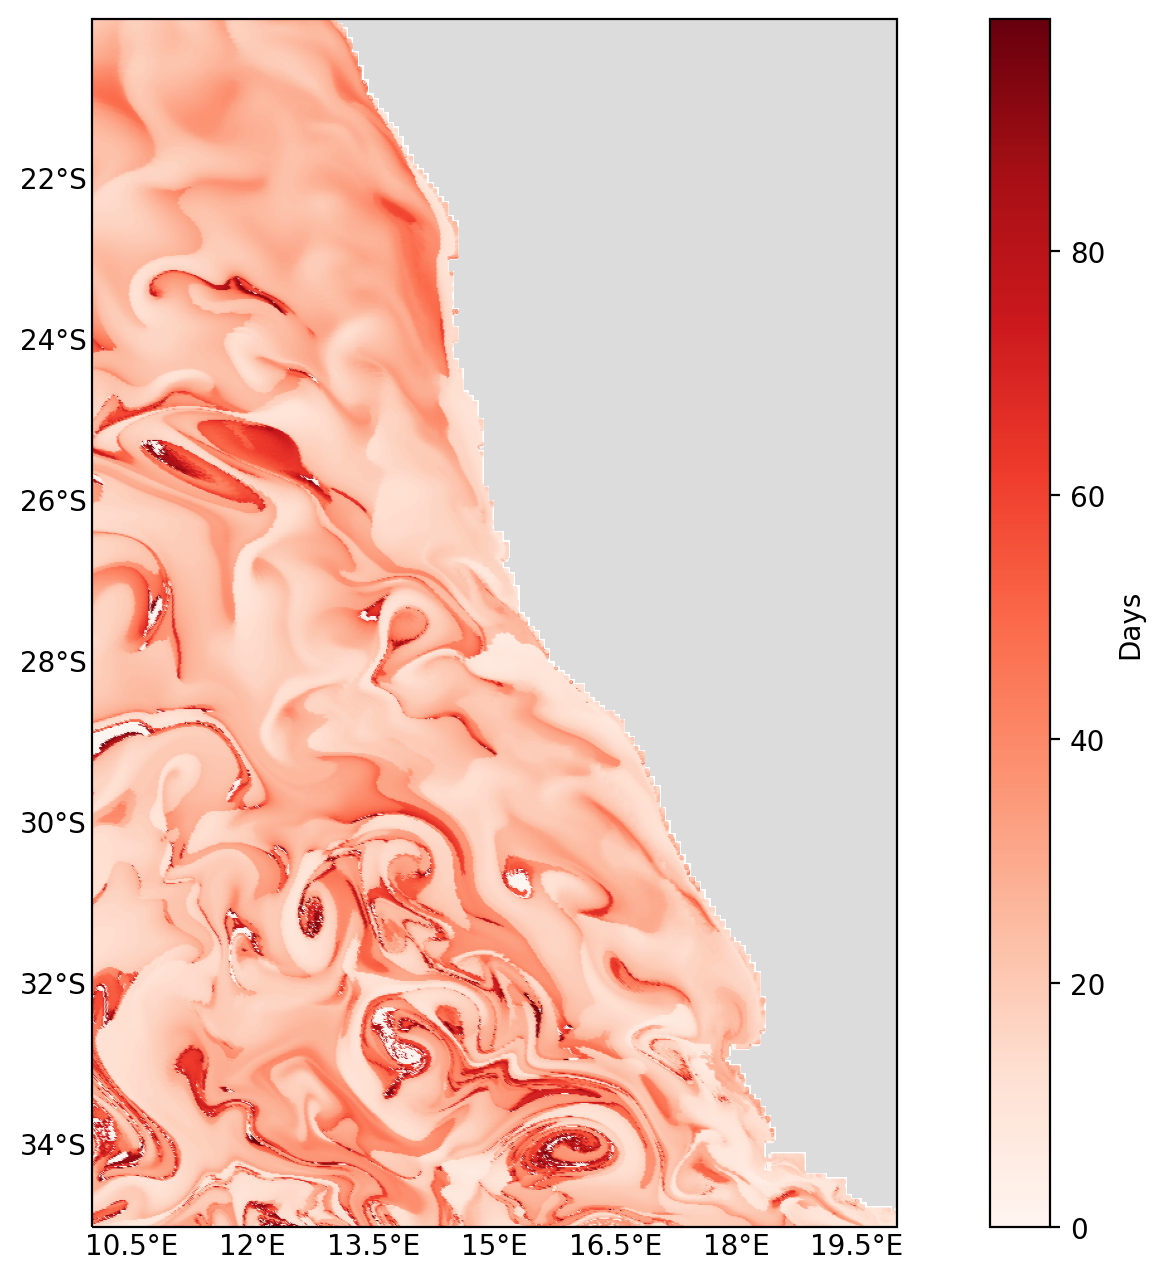

In [16]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(10, 20)
ax.set_ylim(-35, -20)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
im=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= np.argmax(sep_array_2_3>delta_d, axis = 1), s=0.1, cmap='Reds')
fig.colorbar(im, ax=ax, label='Days')

plt.show()

In [51]:
bins=np.arange(0,101,5)
bins

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

DescribeResult(nobs=370831, minmax=(0, 99), mean=25.942057163505748, variance=189.22067249756557, skewness=1.8012576924063946, kurtosis=4.656171197582509)


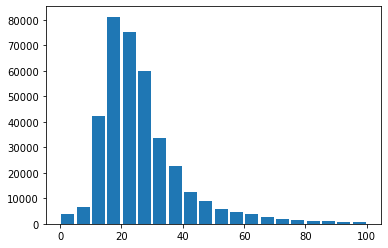

In [52]:
diff_2_3 = np.argmax(sep_array_2_3>delta_d, axis = 1)
print(stats.describe(diff_2_3, axis= None, nan_policy='omit'))

count23, bins_count23, _ = plt.hist(diff_2_3, bins=bins, rwidth=0.85)
pdf_2_3 = count23/np.sum(count23)
cdf_2_3 = np.cumsum(pdf_2_3)

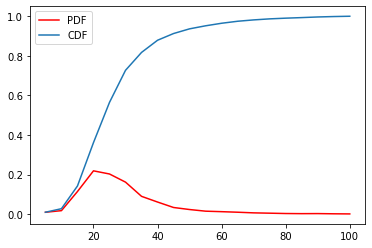

In [53]:
plt.plot(bins_count23[1:], pdf_2_3, color="red", label="PDF")
plt.plot(bins_count23[1:], cdf_2_3, label="CDF")
plt.legend()

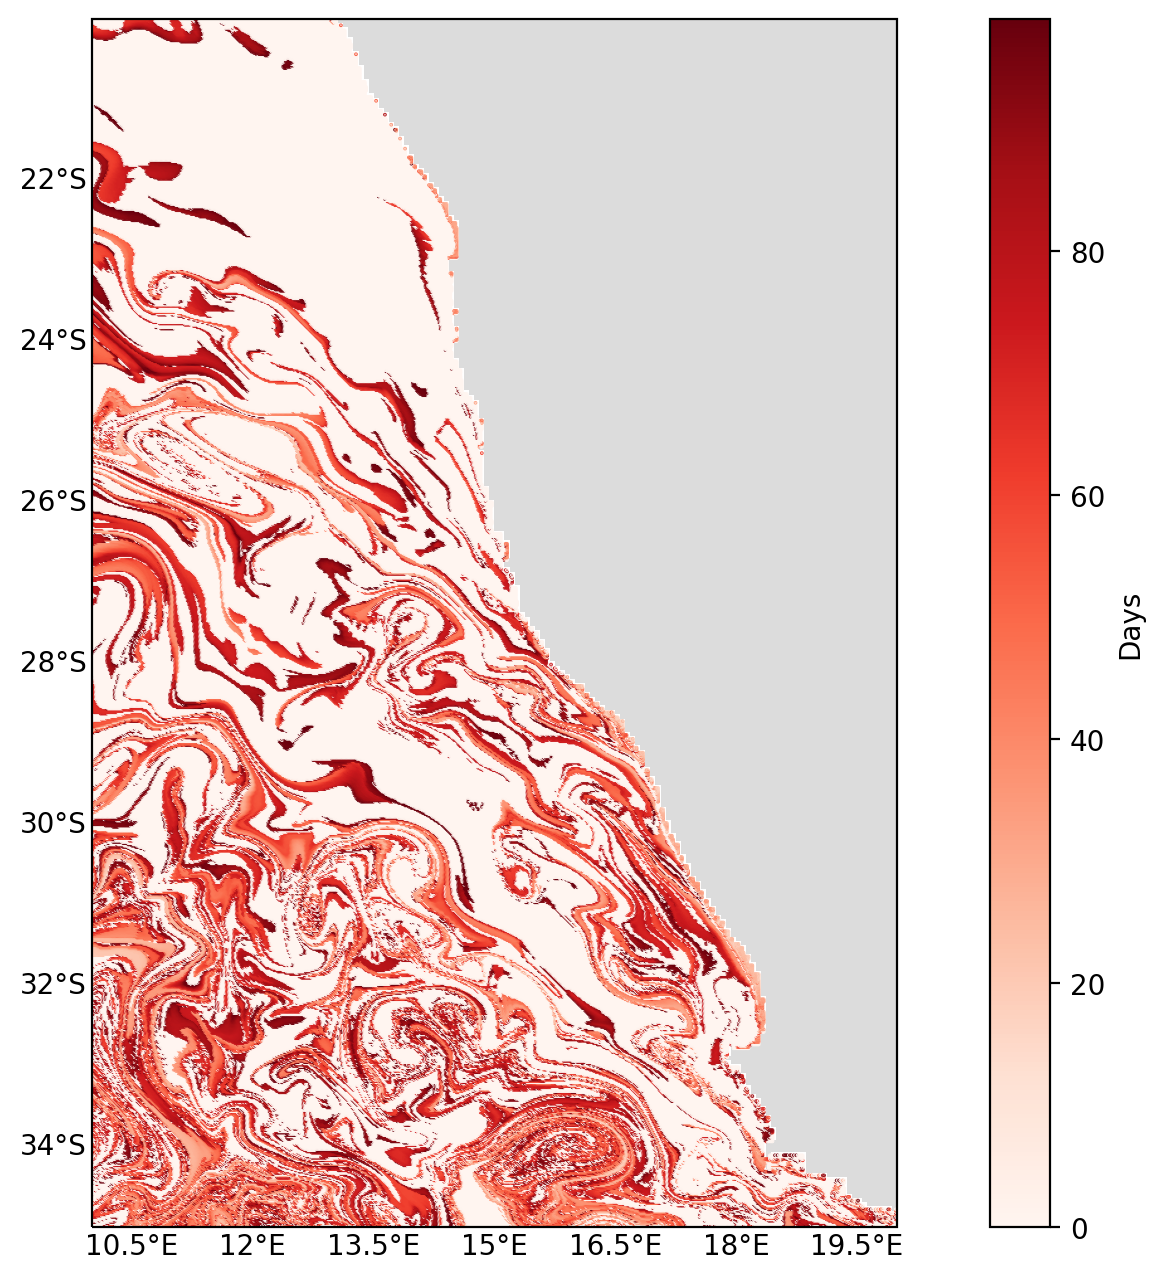

In [18]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(10, 20)
ax.set_ylim(-35, -20)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
im=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= np.argmax(sep_array_1_2>delta_d, axis = 1), s=0.1, cmap='Reds')
fig.colorbar(im, ax=ax, label='Days')

plt.show()

DescribeResult(nobs=370831, minmax=(0, 99), mean=24.237118795354217, variance=1156.6018631373017, skewness=0.9034278170140604, kurtosis=-0.8460564416648082)


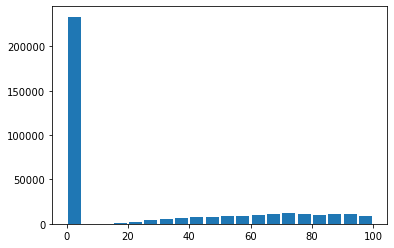

In [54]:
diff_1_2 = np.argmax(sep_array_1_2>delta_d, axis = 1)
print(stats.describe(diff_1_2, axis= None, nan_policy='omit'))

count12, bins_count12, _ = plt.hist(diff_1_2, bins=bins, rwidth=0.85)
pdf_1_2 = count12/np.sum(count12)
cdf_1_2 = np.cumsum(pdf_1_2)

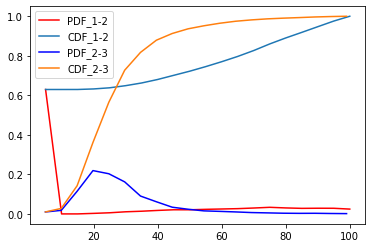

In [55]:
plt.plot(bins_count12[1:], pdf_1_2, color="red", label="PDF_1-2")
plt.plot(bins_count12[1:], cdf_1_2, label="CDF_1-2")
plt.plot(bins_count[1:], pdf_2_3, color="blue", label="PDF_2-3")
plt.plot(bins_count[1:], cdf_2_3, label="CDF_2-3")
plt.legend()

<h3> Plot the CDFs with different delta_d setting

In [100]:
def get_diff_CDF(array, delta_d, bins):
    diff = np.argmax(array>delta_d, axis = 1)
    print(stats.describe(diff, axis= None)) #, nan_policy='omit'

    # count, bins_count, _ = plt.hist(diff, bins=bins, rwidth=0.85)
    count, bins_count= np.histogram(diff, bins=bins)

    pdf = count/np.sum(count)
    cdf = np.cumsum(pdf)
    return cdf

DescribeResult(nobs=370831, minmax=(0, 99), mean=28.294039602945816, variance=284.8640919443798, skewness=1.2308185493526003, kurtosis=2.0171525719083414)
DescribeResult(nobs=370831, minmax=(0, 30), mean=3.8624305950689126, variance=2.838073771829248, skewness=1.3472027491860588, kurtosis=4.023985561460083)


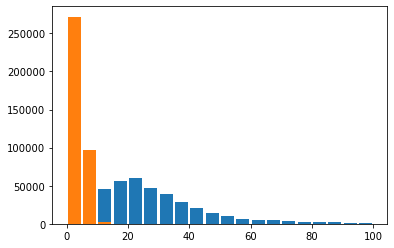

In [67]:
delta_new = 10 
cdf1 = get_diff_CDF(sep_array_1_2, delta_new, bins)
cdf2= get_diff_CDF(sep_array_2_3, delta_new, bins)


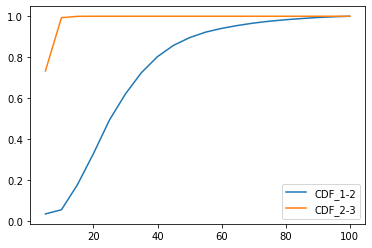

In [68]:
plt.plot(bins[1:], cdf1, label="CDF_1-2")
plt.plot(bins[1:], cdf2, label="CDF_2-3")
plt.legend()

<h3> sensitivity to delta

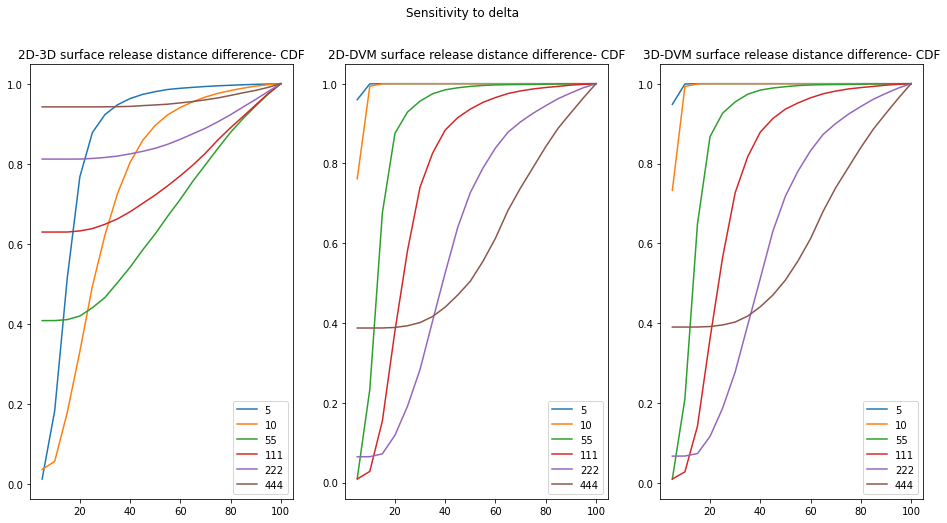

In [93]:
deltas=[5, 10, 55, 111, 222,444]
fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=3)
fig.suptitle('Sensitivity to delta')
for d in deltas:
    cdf1 = get_diff_CDF(sep_array_1_2, d, bins)
    ax[0].plot(bins[1:], cdf1, label=d)

    cdf2 = get_diff_CDF(sep_array_1_3, d, bins)
    ax[1].plot(bins[1:], cdf2, label=d)
     
    cdf3 = get_diff_CDF(sep_array_2_3, d, bins)
    ax[2].plot(bins[1:], cdf3, label=d)

ax[0].set_title("2D-3D surface release distance difference- CDF")
ax[0].legend()  
ax[1].set_title("2D-DVM surface release distance difference- CDF")
ax[1].legend() 
ax[2].set_title("3D-DVM surface release distance difference- CDF")
ax[2].legend() 

DescribeResult(nobs=370831, minmax=(0, 99), mean=19.285720449476987, variance=140.3156885243807, skewness=2.424989738195652, kurtosis=8.960546783835426)
DescribeResult(nobs=370831, minmax=(0, 79), mean=2.577473296461191, variance=1.5898982847378003, skewness=2.7027156971636805, kurtosis=76.78319802647802)
DescribeResult(nobs=370831, minmax=(0, 29), mean=2.6944915608457762, variance=1.7700141248317007, skewness=1.5203543895908578, kurtosis=4.451985867135896)
DescribeResult(nobs=370831, minmax=(0, 99), mean=29.96770226868843, variance=319.35483690659356, skewness=1.072052541535019, kurtosis=1.4329532603932744)
DescribeResult(nobs=370831, minmax=(0, 79), mean=3.9768870455814103, variance=2.9261249059344667, skewness=1.8353166111504353, kurtosis=24.003205009621826)
DescribeResult(nobs=370831, minmax=(0, 30), mean=4.124787302032463, variance=3.1144957732611918, skewness=1.3668832028589344, kurtosis=4.243792804904624)
DescribeResult(nobs=370831, minmax=(0, 99), mean=34.52209766713139, varian

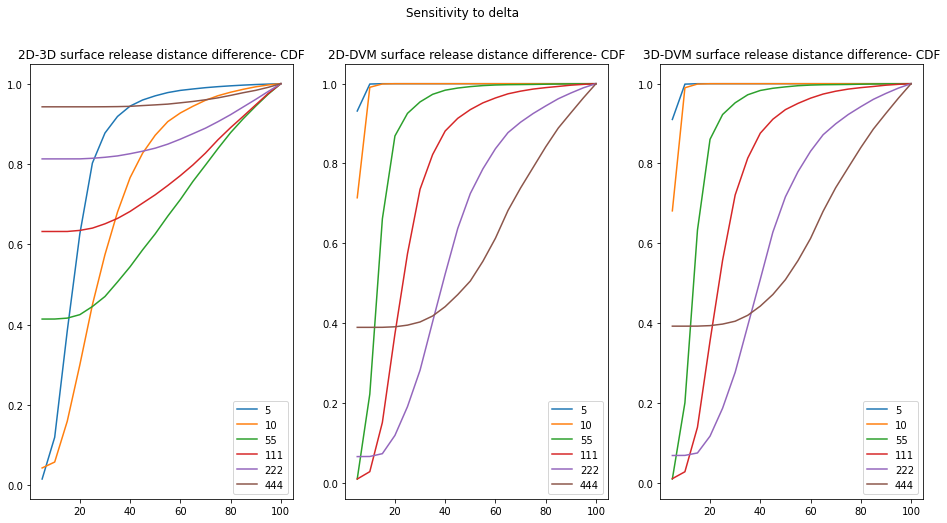

In [101]:
deltas=[5, 10, 55, 111, 222,444]
fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=3)
fig.suptitle('Sensitivity to delta')
for d in deltas:
    cdf1 = get_diff_CDF(sep_array_1_2, d, bins)
    ax[0].plot(bins[1:], cdf1, label=d)

    cdf2 = get_diff_CDF(sep_array_1_3, d, bins)
    ax[1].plot(bins[1:], cdf2, label=d)
     
    cdf3 = get_diff_CDF(sep_array_2_3, d, bins)
    ax[2].plot(bins[1:], cdf3, label=d)

ax[0].set_title("2D-3D surface release distance difference- CDF")
ax[0].legend()  
ax[1].set_title("2D-DVM surface release distance difference- CDF")
ax[1].legend() 
ax[2].set_title("3D-DVM surface release distance difference- CDF")
ax[2].legend() 

DescribeResult(nobs=370831, minmax=(0, 29), mean=2.3557334742780403, variance=1.4610244782613704, skewness=1.567438186983732, kurtosis=5.412993678075267)
DescribeResult(nobs=370831, minmax=(0, 30), mean=3.8624305950689126, variance=2.838073771829248, skewness=1.3472027491860588, kurtosis=4.023985561460083)
DescribeResult(nobs=370831, minmax=(0, 99), mean=14.313636130744193, variance=60.09230708458771, skewness=3.266848984975948, kurtosis=18.41638811614355)
DescribeResult(nobs=370831, minmax=(0, 99), mean=25.942057163505748, variance=189.22067249756557, skewness=1.8012576924063946, kurtosis=4.656171197582509)
DescribeResult(nobs=370831, minmax=(0, 99), mean=40.72843694297402, variance=435.1801162632614, skewness=0.36250386510280574, kurtosis=0.2669792280143186)


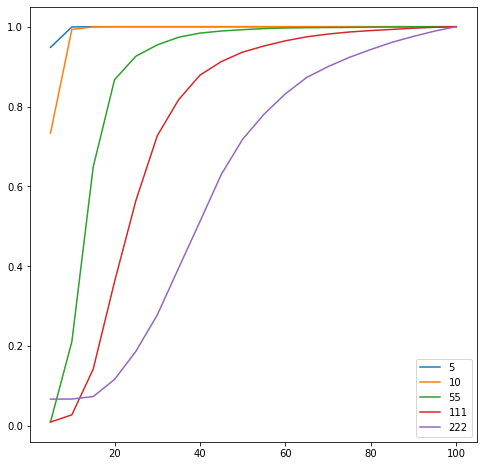

In [86]:
fig=plt.figure(figsize=(8,8))
for d in deltas:
    cdf1 = get_diff_CDF(sep_array_2_3, d, bins)
    plt.plot(bins[1:], cdf1, label=d)
plt.legend()  